In [ ]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
import pickle
from google.colab.patches import cv2_imshow
import math
np.random.seed(42)

## Download and Prepare the Dataset

We will use the <a href="https://public.roboflow.com/object-detection/vehicles-openimages" target="_blank">Vehicles-OpenImages</a> dataset for training the custom YOLOv5 object detector.

In [ ]:
if not os.path.exists('train'):
    !curl -L "https://public.roboflow.com/ds/xKLV14HbTF?key=aJzo7msVta" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    
    dirs = ['train', 'valid', 'test']

    for i, dir_name in enumerate(dirs):
        all_image_names = sorted(os.listdir(f"{dir_name}/images/"))
        for j, image_name in enumerate(all_image_names):
            if (j % 2) == 0:
                file_name = image_name.split('.jpg')[0]
                os.remove(f"{dir_name}/images/{image_name}")
                os.remove(f"{dir_name}/labels/{file_name}.txt")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   893  100   893    0     0   3832      0 --:--:-- --:--:-- --:--:--  3832
100 38.4M  100 38.4M    0     0  72.6M      0 --:--:-- --:--:-- --:--:--  354M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/00dea1edf14f09ab_jpg.rf.3f17c8790a68659d03b1939a59ccda80.jpg  
 extracting: test/images/00dea1edf14f09ab_jpg.rf.KJ730oDTFPdXdJxvSLnX.jpg  
 extracting: test/images/00e481ea1a520175_jpg.rf.6e6a8b3b45c9a11d106958f88ff714ea.jpg  
 extracting: test/images/00e481ea1a520175_jpg.rf.MV6sZ8QCFwFeMYaI2tHm.jpg  
 extracting: test/images/08c8b73e0c2e296e_jpg.rf.7IkYAamjZhnwsoXSrwKt.jpg  
 extracting: test/images/08c8b73e0c2e296e_jpg.rf.effa65856584463c08848031cab357b9.jpg  
 extractin

The original data had two instances of each image and label file. The rest of the code in the above block deletes the duplicate image and it's corresponding text file containing the label.

The dataset is structured in the following manner:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images. 

The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format.

In [ ]:
class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

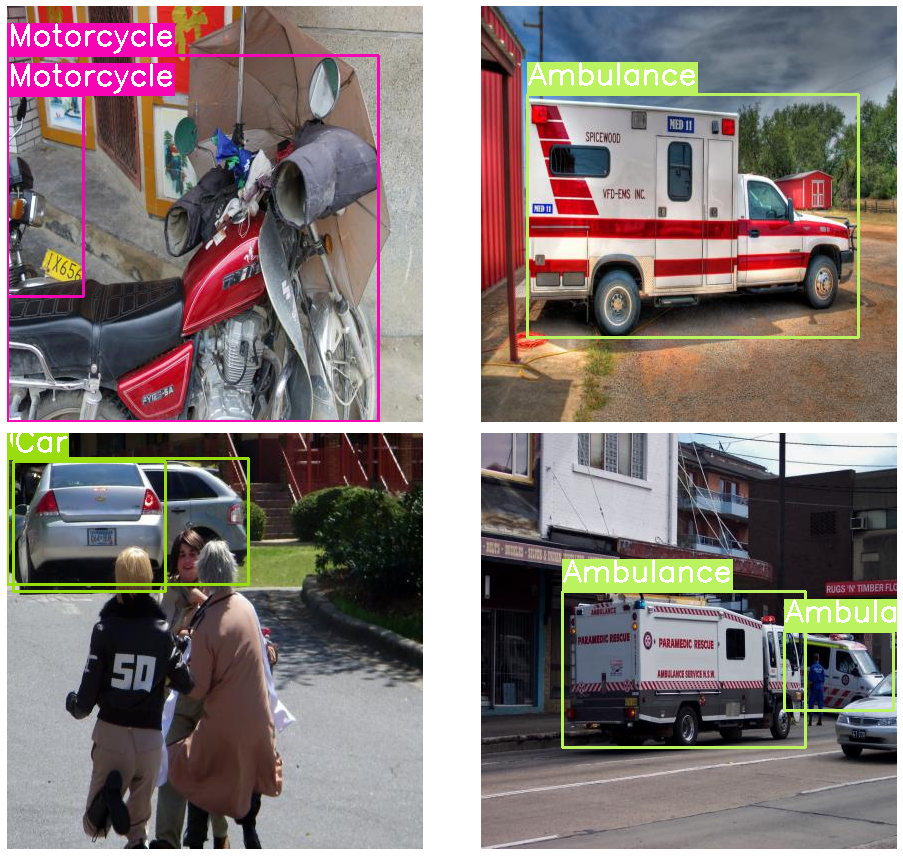

In [ ]:
# Visualize a few training images.
plot(
    image_paths='train/images/*', 
    label_paths='train/labels/*',
    num_samples=4,
)

## Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [ ]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

## Cloning YOLOV5 Repository

In [ ]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 11748, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 11748 (delta 47), reused 88 (delta 34), pack-reused 11632
Receiving objects: 100% (11748/11748), 12.47 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (8040/8040), done.


In [ ]:
%cd yolov5/
!pwd

/content/yolov5
/content/yolov5


In [ ]:
!pip install -r requirements.txt

## Training using YOLOV5

The next step is to train the neural network model.
I have used yolov5 small with 7.2 million parameters.


In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5s.pt \
    --img 640 --epochs {30} --batch-size 16 --name {RES_DIR}

Current number of result directories: 1
results_2
train: weights=yolov5s.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-3-gfe809b8 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t

### Inference


1.   Running inference on the input video with the best weights.
2.   I have modified detect.py such that, instead of saving the images it will the coordinates of the bounding boxes as a pickle file.



In [ ]:
!python detect.py --weights /content/best.pt \--source /content/Traffic.mp4 --name {INFER_DIR}

YOLOv5 🚀 v6.2-10-g5c854fa Python-3.7.13 torch-1.12.1+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/239) /content/Traffic.mp4: 384x640 3 Cars, Done. (0.420s)
video 1/1 (2/239) /content/Traffic.mp4: 384x640 3 Cars, Done. (0.381s)
video 1/1 (3/239) /content/Traffic.mp4: 384x640 3 Cars, Done. (0.387s)
video 1/1 (4/239) /content/Traffic.mp4: 384x640 3 Cars, Done. (0.374s)
video 1/1 (5/239) /content/Traffic.mp4: 384x640 3 Cars, Done. (0.378s)
video 1/1 (6/239) /content/Traffic.mp4: 384x640 3 Cars, Done. (0.372s)
video 1/1 (7/239) /content/Traffic.mp4: 384x640 3 Cars, Done. (0.366s)
video 1/1 (8/239) /content/Traffic.mp4: 384x640 3 Cars, Done. (0.358s)
video 1/1 (9/239) /content/Traffic.mp4: 384x640 3 Cars, Done. (0.393s)
video 1/1 (10/239) /content/Traffic.mp4: 384x640 3 Cars, Done. (0.368s)
video 1/1 (11/239) /content/Traffic.mp4: 384x640 2 Cars, Done. (0.357s)
video 1/1 (12/239) /content/Traffic.mp4: 384x640 1 Car, Done. (

In [ ]:
#opengin the pickle file that has bounding box coordinates and storing it in to a variable.
with open('/content/listfile', 'rb') as fp:
  n_list = pickle.load(fp)

In [ ]:
#kalmanfilter to predict the trajectory of an object.


class KalmanFilter:
    kf = cv2.KalmanFilter(4, 2)
    kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)


    def predict(self, coordX, coordY):
        ''' This function estimates the position of the object'''
        measured = np.array([[np.float32(coordX)], [np.float32(coordY)]])
        self.kf.correct(measured)
        predicted = self.kf.predict()
        x, y = int(predicted[0]), int(predicted[1])
        return x, y


In [ ]:
#EuclideanDistTracker to track objects in the frame
class EuclideanDistTracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 0


    def update(self, objects_rect):
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2

            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 50:
                    self.center_points[id] = (cx, cy)
                    print(self.center_points)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids

In [20]:
#function to create directory
def create_dir(dirName):
  if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
  else:    
    print("Directory " , dirName ,  " already exists")


In [40]:
#Function to track and predict the trajectory of the object
def object_tracking(save_path, source_path, bounding_boxes):

  tracker = EuclideanDistTracker()
  kf = KalmanFilter()
  cap = cv2.VideoCapture(source_path)
  create_dir(save_path)


  k=0
  while True:
      ret, frame = cap.read()
      if ret is False:
        break
      height, width, _ = frame.shape
      #print(height, width)

      

      #Extract Region of interest
      #roi = frame[100: 700, 100:900]
      roi = frame


      boxes_ids = tracker.update(np.array(n_list[k][0].cpu().detach().numpy()))
      #print(boxes_ids)
      for box_id in np.array(boxes_ids):
          x, y, w, h, id = box_id
          cx = int((x + w) / 2)
          cy = int((y + h) / 2)
          
          predicted = kf.predict(cx, cy)
          #print(x,y,w,h,id)
          cv2.putText(roi, str(id), (int(x), int(y) - 15), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
          cv2.rectangle(roi, (int(x), int(y)), (int(w), int(h)), (0, 255, 0), 3)

          cv2.circle(roi, (cx, cy), 5, (0, 0, 255), 4)
          cv2.circle(roi, (predicted[0], predicted[1]), 5, (255, 0, 0), 4)


      #cv2_imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
      #cv2_imshow(frame)
      cv2.imwrite(save_path+'/'+str(k+100)+'.jpg', roi)
      k+=1

      key = cv2.waitKey(30)
      if key == 27:
          break

  cap.release()
  cv2.destroyAllWindows()

In [41]:
object_tracking('/content/save1', '/content/Traffic.mp4', n_list)

Directory  /content/save1  Created 
{0: (847.0, 427.0), 1: (1062.0, 439.0), 2: (788.0, 131.0)}
{0: (850.0, 452.0), 1: (1062.0, 439.0), 2: (788.0, 131.0)}
{0: (850.0, 452.0), 1: (1062.0, 439.0), 2: (787.0, 133.0)}
{1: (1079.0, 466.0), 0: (850.0, 452.0), 2: (787.0, 133.0)}
{1: (1079.0, 466.0), 0: (847.0, 484.0), 2: (787.0, 133.0)}
{1: (1079.0, 466.0), 0: (847.0, 484.0), 2: (790.0, 140.0)}
{1: (1079.0, 466.0), 0: (855.0, 516.0), 2: (790.0, 140.0)}
{1: (1101.0, 497.0), 0: (855.0, 516.0), 2: (790.0, 140.0)}
{1: (1101.0, 497.0), 0: (855.0, 516.0), 2: (790.0, 144.0)}
{0: (864.0, 559.0), 1: (1101.0, 497.0), 2: (790.0, 144.0)}
{0: (864.0, 559.0), 1: (1101.0, 497.0), 2: (790.0, 146.0), 3: (1128.0, 542.0)}
{0: (864.0, 559.0), 3: (1150.0, 577.0), 2: (790.0, 146.0), 4: (875.0, 614.0)}
{0: (864.0, 559.0), 3: (1150.0, 577.0), 2: (793.0, 146.0), 4: (875.0, 614.0)}
{4: (875.0, 614.0), 3: (1150.0, 577.0), 2: (793.0, 146.0)}
{4: (875.0, 614.0), 3: (1150.0, 577.0), 2: (793.0, 146.0)}
{4: (875.0, 614.0), 3

In [54]:
#creating a video from imgages
img_array = []
for i in range(len(glob.glob('/content/save*.jpg'))):
    filename = "/content/save/"+str(i)+'.jpg'
    #print(filename)
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('/content/project_.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()